In [6]:
import os

# Prepend TeX Live 2025 bin directory to PATH
os.environ['PATH'] = '/scratch/ope4/texlive/2025/bin/x86_64-linux:' + os.environ['PATH']

# Optional: check that the correct latex is found
!which latex
!latex --version


/scratch/ope4/texlive/2025/bin/x86_64-linux/latex
pdfTeX 3.141592653-2.6-1.40.28 (TeX Live 2025)
kpathsea version 6.4.1
Copyright 2025 Han The Thanh (pdfTeX) et al.
There is NO warranty.  Redistribution of this software is
covered by the terms of both the pdfTeX copyright and
the Lesser GNU General Public License.
For more information about these matters, see the file
named COPYING and the pdfTeX source.
Primary author of pdfTeX: Han The Thanh (pdfTeX) et al.
Compiled with libpng 1.6.46; using libpng 1.6.46
Compiled with zlib 1.3.1; using zlib 1.3.1
Compiled with xpdf version 4.04


## Estimating space- and time-varying transmission rate from data
# Exercise 1


In [1]:
#CustomScopes give you the most flexibility in representing geography.

#nodes = number of locations
#node IDS = A,B,C: the name of our grid_cell/polygons
#node labels is the same as the ID
from epymorph.kit import *
import numpy as np

from epymorph.kit import *
from epymorph.adrio import acs5
from epymorph.initializer import Proportional



In [2]:
scope = CustomScope(["A", "B", "C", "D", "E", "F", "G", "H"])
scope

In [3]:
import numpy as np

centroids = np.array(
    [
        #(-111.5, 33.8),
        #(-106.6, 35.2),
        #(-109.3, 32.1),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
        (-112,	36),
    ],
    dtype=CentroidDType  # already imported with epymorph.kit
)



In [4]:
"""Defines a compartmental IPM for a generic SIRS model."""

from sympy import Max

from epymorph.attribute import AttributeDef
from epymorph.compartment_model import CompartmentModel, compartment, edge
from epymorph.data_shape import Shapes


class SIRS_TREES(CompartmentModel):
    """A basic SIRS model."""

    compartments = [
        compartment("S", tags=["immobile"]), #Susceptible
        compartment("I1", tags=["immobile"]), #INFECTIOUS STAGE 1
        #compartment("I2", tags=["immobile"]), #INFECTIOUS STAGE 2
        #compartment("I3", tags=["immobile"]), #INFECTIOUS STAGE 3
        compartment("R", tags=["immobile"]), #RECOVERED
        compartment("D", tags=["immobile"]), #DEATH
        compartment("X", tags=["mobile"]), #INSECT
    ]

    requirements = [
        AttributeDef("beta", type=float, shape=Shapes.TxN, comment="infectivity"),
        AttributeDef(
            "gamma",
            type=float,
            shape=Shapes.TxN,
            comment="progression from infected to recovered",
        ),
        AttributeDef(
            "xi",
            type=float,
            shape=Shapes.TxN,
            comment="progression from recovered to susceptible",
        ),

        AttributeDef(
            "birth_rate",
            type=float,
            shape=Shapes.TxN,
            comment="birth rate per day per capita",
        ),
    ]

    def edges(self, symbols):
        [S, I1, R, D, X] = symbols.all_compartments #I2, I3,
        [β, γ, ξ, br] = symbols.all_requirements

        # formulate N so as to avoid dividing by zero;
        # this is safe in this instance because if the denominator is zero,
        # the numerator must also be zero
        N = Max(1, S + I1 + R + D + X) #I2 + I3 + 

        return [
            edge(S, I1, rate=β * S * X / N), ## S->I1 influenced by X
            #edge(I1, I2, rate=γ * I2),
            #edge(I2, I3, rate=γ * I3),
            edge(I1, D, rate=γ * D),
            edge(I1, R, rate=ξ * I1),
            #edge(I2, R, rate=ξ * I2),
            #edge(I3, R, rate=ξ * I3),  ##according to Monica, once it gets to noticable changes, the trees never recover
            edge(R, S, rate=ξ * R),
            edge(X, X, rate=0),
            edge(BIRTH, X, rate = br * X),   #rate of birth in the Insect compartment alone          
        ]


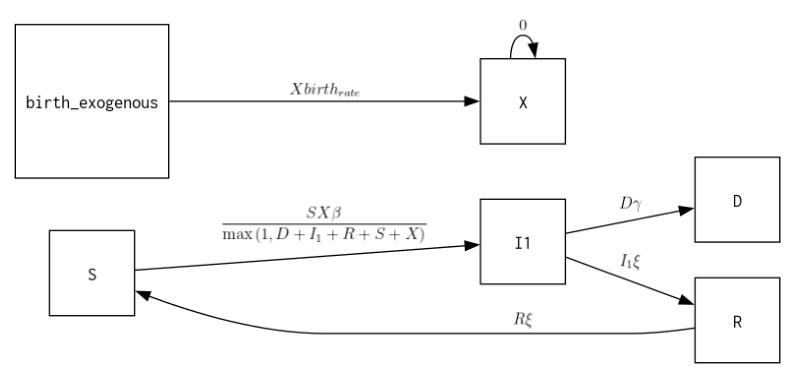

In [7]:
##model conceptual diagram

SIRS_TREES().diagram()

In [8]:
import numpy as np

from epymorph.kit import *
from epymorph.adrio import acs5
from epymorph.initializer import Proportional

In [9]:

#Construct a RUME with a scope consisting of our scope, 
# but assume that there is no movement between the states. Essentially, 
# this simulates four independent populations. Use an SIRH IPM. In each State, 
# initialize a small fraction initially infectious. Run for 26 weeks.

n = 8 #number of scope
rume = SingleStrataRUME.build(
    #ipm=ipm.SIRH(),
    ipm=SIRS_TREES(),
    mm=mm.No(),
    scope=scope,
    init=Proportional(
        ratios=np.broadcast_to(
            np.array([9999, 1, 0, 0, 100], dtype=np.int64), shape=(n, 5) #number of individual in each compartment, so S= 9999 etc.
        )
    ),
    #init=init,
    time_frame=TimeFrame.of("2021-07-25", 7 * 104 + 1),
    params={
        "beta": 0.3,  # Placeholder value
        "gamma": 0.2,
        "xi": 1 / 365,
        "birth_rate": 1 / (70 * 365), ## how much do they reproduce in a year?
        "hospitalization_prob": 200 / 100_000,
        "hospitalization_duration": 5.0, ##ask tyler if this duration can be made into number of days the insect stays in a particular tree etc
        "population": [
            #4_151_502, # Arizona
            #4_773_714, # Colorado
            #4_117_522#, # New Mexico
            #4_271_616, # Utah
            1_326, #total tree population per 100m by 100m grid
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326,
            1_326
        ],
    },
)

In [10]:
#Specify the filter type (Particle Filter). 
# Note that here is where we could specify the resampler used by the filter, 
# but we’ll just use the default (not localized).

from epymorph.parameter_fitting.filter.particle_filter import ParticleFilter

filter_type = ParticleFilter(num_particles=300)

In [ ]:
#Specify the parameters to be estimated, 
# modeling the beta in each state using geometric Brownian motion with a uniform initial distribution.

from epymorph.parameter_fitting.distribution import Uniform
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_fitting.dynamics import GeometricBrownianMotion

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.1, b=0.8),
        dynamics=GeometricBrownianMotion(volatility=0.1),
    ),
}

In [18]:
import pandas as pd
from epymorph.adrio.cdc import InfluenzaStateHospitalization
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations
from epymorph.time import EveryNDays

# -------------------------
# Step 1: Observed data
# -------------------------
nodes = ["A", "B", "C", "D", "E", "F", "G", "H"]
population = [1326] * 8
death_percentages = [18.789615, 8.708416, 19.639209, 14.259614, 
                     19.297432, 13.18899, 22.60519, 6.599833]  # <-- your data

# 2021 baseline (day 0, all 0 deaths)
baseline = pd.DataFrame({
    "time": [0] * len(nodes),
    "geo": nodes,
    "value": [0] * len(nodes)   # no deaths at baseline
})

# 2023 observations (day 730 ~ 2 years later)
deaths = [round(population[i] * death_percentages[i] / 100) for i in range(len(nodes))]
later = pd.DataFrame({
    "time": [730] * len(nodes),
    "geo": nodes,
    "value": deaths
})

# Combine into single dataframe
obs_data = pd.concat([baseline, later], ignore_index=True)

obs_data

,time,geo,value
0,0,A,0
1,0,B,0
2,0,C,0
3,0,D,0
4,0,E,0
5,0,F,0
6,0,G,0
7,0,H,0
8,730,A,249
9,730,B,115


In [23]:

from epymorph.adrio.cdc import InfluenzaStateHospitalization
from epymorph.parameter_fitting.likelihood import Poisson
from epymorph.parameter_fitting.utils.observations import ModelLink, Observations
from epymorph.time import EveryNDays

observations = Observations(
    source=obs_data,
    model_link=ModelLink(
        quantity=rume.ipm.select.events("I1->D"),
        time=rume.time_frame.select.all().group(EveryNDays(7)).agg(),
        geo=rume.scope.select.all(),
    ),
    likelihood=Poisson(),
)

print(observations)

In [24]:
#Create the filter simulation object using the RUME.

from epymorph.parameter_fitting.particlefilter_simulation import FilterSimulation

sim = FilterSimulation(
    rume=rume,
    observations=observations,
    filter_type=filter_type,
    params_space=params_space,
)

ValueError: Unsupported data source provided.